In [1]:
import transformers
import sqlite3
import jsonlines
import random
from tqdm import tqdm

# Show the MSMARCO data format

In [2]:
!ls /home/ryparmar/MSMARCO-Passage-Ranking/

collection.tar.gz  queries.dev.tsv   queries.train.tsv
qrels.dev.tsv	   queries.eval.tsv  triples.train.small.tar.gz
qrels.train.tsv    queries.tar.gz    triples.train.small.tsv


In [3]:
!zcat /home/ryparmar/MSMARCO-Passage-Ranking/collection.tar.gz | head -n 2

collection.tsv                                                                                      0000777 0001750 0001750 26636750554 13400073633 015704  0                                                                                                    ustar   spacemanidol                    spacemanidol                                                                                                                                                                                                           0	The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.
1	The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on his

In [4]:
!zcat /home/ryparmar/MSMARCO-Passage-Ranking/triples.train.small.tar.gz | head -n 2

triples.train.small.tsv                                                                             0000770 �    z�4001001 �      � �13321546425 016554  0                                                                                                    ustar   bmitra                          REDMOND+Group(513)                                                                                                                                                                                                     is a little caffeine ok during pregnancy	We donât know a lot about the effects of caffeine during pregnancy on you and your baby. So itâs best to limit the amount you get each day. If youâre pregnant, limit caffeine to 200 milligrams each day. This is about the amount in 1Â½ 8-ounce cups of coffee or one 12-ounce cup of coffee.	It is generally safe for pregnant women to eat chocolate because studies have shown to prove certain benefits of eating chocolate during pregnancy. Howe

In [5]:
!cat /home/ryparmar/MSMARCO-Passage-Ranking/queries.train.tsv | head -n 2

121352	define extreme
634306	what does chattel mean on credit history
cat: write error: Broken pipe


In [6]:
!zcat /home/ryparmar/MSMARCO-Passage-Ranking/queries.tar.gz | head -n 2

queries.dev.tsv                                                                                     0000664 0001750 0001750 00020762502 13372646016 014016  0                                                                                                    ustar   erasmus                         erasmus                                                                                                                                                                                                                1048578	cost of endless pools/swim spa
1048579	what is pcnt

gzip: stdout: Broken pipe


# Convert CTK data into MSMARCO format

query \t positive_passage \t negative_passage

or 

query_id \t pos_pass_id \t neg_pass_id

In [2]:
ctk = '/mnt/data/factcheck/CTK/par5'
articles = f'{ctk}/interim/ctk.db'
articles_filtered = f'{ctk}/interim/ctk_filtered.db'

claims = '/mnt/data/factcheck/CTK/dataset/v2.1/nfc'  #ctk
train = f'{claims}/train.jsonl'
dev = f'{claims}/dev.jsonl'
test = f'{claims}/test.jsonl'

In [3]:
conn = sqlite3.connect(articles)  
c = conn.cursor()
c.execute("SELECT * FROM documents")
paragraphs = {i[0]: i[-2] for i in c.execute("SELECT * FROM documents").fetchall()}

KeyboardInterrupt: 

In [4]:
# [description[0] for description in c.description]

In [4]:
conn = sqlite3.connect(articles_filtered)  
c = conn.cursor()
c.execute("SELECT * FROM documents")
paragraphs_filtered = {i[0]: i[-1] for i in c.execute("SELECT * FROM documents").fetchall()}

In [5]:
# documents = [i for i in c.execute("SELECT * FROM documents").fetchall()]
# documents[0]

In [6]:
[description[0] for description in c.description]

['id', 'did', 'bid', 'date', 'keywords', 'text']

# Plot paragraph len distribution

In [7]:
lens = [len(par.split()) for i, par in paragraphs_filtered.items()]

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

In [ ]:
c = 0
for i, par in paragraphs_filtered.items():
    print(len(par.split()), par)
    c += 1
    if c == 5:
        break

In [ ]:
sum([l > 180 for l in lens])

In [ ]:
sum([l > 140 for l in lens])

In [ ]:
len(lens)

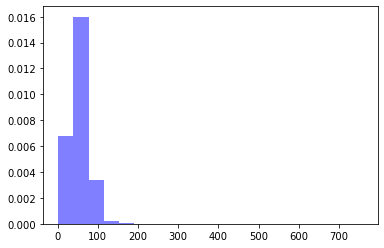

In [9]:
plt.hist(lens, 20,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

# Data prep for ColBERT

In [8]:
# Count wrongly splitted paragraphs
dot, ndot = 0, 0
for idx, d in paragraphs_filtered.items():
    if d.strip().endswith('.'):# and len(d.split(';')) < 3:
        dot += 1
#         print(d)
    else: #if len(d.split()) > 8:
        ndot += 1
#         print(d)

print(dot, ndot)

11027897 2591676


In [10]:
def transform_ctk(pars: list, par_ids: list):
    """
    Transform paragraphs, paragraph_ids into dicts of article: paragraphs and article_id: paragraph_ids
    This is done in order to have an unified structure for all the data: document-paragraph-sentence in a dictionary of 
    articles.
    Used for CTK data which have paragraph granularity in default.
    """
    docs, doc_indices, par_indices = {}, [], []
    for par, idx in tqdm(zip(pars, par_ids), desc='Transforming data'):
        doc_title = idx.split('_')[0]
        par_indices.append(idx)
        if doc_title in docs:
            docs[doc_title].append(par)
        else:
            docs[doc_title] = [par]
        doc_indices.append(doc_title)
    doc_indices = list(set(doc_indices))
    assert len(doc_indices) == len(docs)
    return docs, doc_indices, par_indices

In [12]:
for k,v in paragraphs_filtered.items():
    print(k, v)
    break

T201608150566901_0 Dokazování v kauze korupce na finančním úřadu se blíží ke konci


In [13]:
def remove_invalid_pars(pars):
    """Removes paragraphs which doesnt end with '.' or ends with '...'"""
    ret_pars = {}
    for idx, p in tqdm(pars.items()):
        if not p.strip().endswith('...') and p.strip().endswith('.'):
            ret_pars[idx] = p
    return ret_pars

In [14]:
paragraphs_filtered = remove_invalid_pars(paragraphs_filtered)

100%|██████████| 13619573/13619573 [00:14<00:00, 934215.11it/s]


In [15]:
docs_filtered, doc_filtered_ids, par_filtered_ids = transform_ctk(list(paragraphs_filtered.values()), list(paragraphs_filtered.keys()))

Transforming data: 10938240it [00:26, 415820.96it/s]


In [16]:
for doc_id, doc in docs_filtered.items():
    print(doc_id, doc)
    break
#     if [i for i in range(len(doc))]:
#         print(f"{[i for i in range(len(doc))]} vs {list(doc.keys())}")

T201608150566901 ['Zlín 15. srpna ( ČTK ) - Krajský soud ve Zlíně dokončuje dokazování v korupční kauze kolem finančního úřadu v Kroměříži . Podle obžaloby braly tři úřednice úplatky za ovlivňování daňového řízení . V případu je stíhána i zastupitelka Kroměříže za KSČM Kamila Dudová , která podle obžaloby s korupcí pomáhala , a podnikatel Milan Macourek , v jehož prospěch byla daň krácena . Úřednice i Dudová vinu odmítají , Macourek se přiznal .', 'Dudová podle obžaloby pomáhala s daňovým řízením obchodníkovi s trvanlivými potravinami Macourkovi . Jeho společnosti DUHAN byla podle státní zástupkyně neoprávněně vyplacena daň z přidané hodnoty 22,5 milionu korun a o vyplacení dalších 5,8 milionu se pokusil . Podle obžaloby se na tom podílely pracovnice finančního úřadu Lenka Burianová , Jarmila Červinková a Alena Olšinová , které ale tvrdí , že samy odhalily Macourkův podvod .', 'Dnes u soudu vypovídali svědkové obhajoby , mimo jiné znalci , kteří oponovali odbornému vyjádření zpracované

# Create collection file:  id \t paragraph/article text

new id is created by enumerating -- the ColBERT library works with that numbering

then a new conversion new_id2old_id is created

In [33]:
ROOT = '/home/ryparmar/trained_models/colbert/data'

In [33]:
# collection = f'{ctk}/interim/collection_filtered.tsv'
collection = f'{ROOT}/ctk_title_par5_filtered.tsv'
with open(collection, 'w') as fw:
    for i, (idx, text) in enumerate(paragraphs_filtered.items()):
        fw.write(f"{idx}\t{text}\n")   

In [34]:
!head -n 1 {collection}

T201608150566901_1	Zlín 15. srpna ( ČTK ) - Krajský soud ve Zlíně dokončuje dokazování v korupční kauze kolem finančního úřadu v Kroměříži . Podle obžaloby braly tři úřednice úplatky za ovlivňování daňového řízení . V případu je stíhána i zastupitelka Kroměříže za KSČM Kamila Dudová , která podle obžaloby s korupcí pomáhala , a podnikatel Milan Macourek , v jehož prospěch byla daň krácena . Úřednice i Dudová vinu odmítají , Macourek se přiznal .


In [35]:
!wc -l {collection}

10938240 /home/ryparmar/trained_models/colbert/data/ctk_title_par5_filtered.tsv


In [30]:
# collection = f'{ctk}/interim/old-id2new-id.tsv'
collection = f'{ROOT}/old-id2new-id.tsv'

old2new = {}
new2old = {}

with open(collection, 'w') as fw:
    for i, (idx, text) in enumerate(paragraphs_filtered.items()):
        fw.write(f"{idx}\t{i}\n")
        old2new[idx] = i
        new2old[i] = idx

In [31]:
!head -n 1 {collection}

T201608150566901_1	0


# Create queries files:  id \t claim

In [17]:
with jsonlines.open(dev) as fr:
    dev_claims = [c for c in fr]
    
with jsonlines.open(train) as fr:
    train_claims = [c for c in fr]
    
with jsonlines.open(test) as fr:
    test_claims = [c for c in fr]

In [18]:
for i in train_claims:
    if i['id'] == 135:
        print(i, '\n')
        for ev in i['evidence']:
            print(ev)

{'id': 135, 'verifiable': 'VERIFIABLE', 'label': 'SUPPORTS', 'claim': 'Švédka Astrid Lindgrenová byla spisovatelka.', 'evidence': [[[953, 953, '20050128F00337_1', 0]], [[953, 2000953, '20050128F00337_1', 0]], [[953, 1000953, '20050128F00337_1', 0]], [[953, 3000953, '20050128F00337_1', 0]], [[953, 4000953, '20050128F00337_1', 0]], [[953, 5000953, '20050128F00337_1', 0]]]} 

[[953, 953, '20050128F00337_1', 0]]
[[953, 2000953, '20050128F00337_1', 0]]
[[953, 1000953, '20050128F00337_1', 0]]
[[953, 3000953, '20050128F00337_1', 0]]
[[953, 4000953, '20050128F00337_1', 0]]
[[953, 5000953, '20050128F00337_1', 0]]


In [19]:
print(f"train: {len(train_claims)}\tdev: {len(dev_claims)}\ttest: {len(test_claims)}")

train: 2124	dev: 300	test: 600


In [20]:
train_claims[0]

{'id': 1214,
 'verifiable': 'VERIFIABLE',
 'label': 'SUPPORTS',
 'claim': 'Ukrajina někdejšího gruzínského prezidenta vyhostila zpět směrem na západ.',
 'evidence': [[[4799, 4799, 'T201802220049001_1', 0]]]}

In [41]:
# dev_queries_path = f'{ctk}/ctk-data/dev_queries.tsv'
# test_queries_path = f'{ctk}/ctk-data/test_queries.tsv'
# train_queries_path = f'{ctk}/ctk-data/train_queries.tsv'

dev_queries_path = f'{ROOT}/dev_queries.tsv'
test_queries_path = f'{ROOT}/test_queries.tsv'
train_queries_path = f'{ROOT}/train_queries.tsv'

train_query2id = {c['claim']: i for i, c in enumerate(train_claims)}

for path, claims in zip([train_queries_path, dev_queries_path, test_queries_path], [train_claims, dev_claims, test_claims]):
    with open(path, 'w') as fw:
        for i, c in enumerate(claims):
            fw.write(f"{i}\t{c['claim']}\n")

In [42]:
!head -n 2 {train_queries_path}

0	Ukrajina někdejšího gruzínského prezidenta vyhostila zpět směrem na západ.
1	V roce 1992 byla zrušena podpora malých a středních podniků ze státního rozpočtu.


# Create a synthetic triples

create a synthetic claims and triples

In [21]:
import random
import nltk

In [22]:
def get_diff_rand_chunk_ids(chunks: list):
    """Returns a two random chunk ids from a list of chunks."""
    if len(chunks) > 1:
        rand_sentence_chunk_id, rand_context_chunk_id = random.sample(range(len(chunks)), 2)
        return rand_sentence_chunk_id, rand_context_chunk_id
    elif len(chunks) > 0:
        return 0, 0
    else:
        print("ERROR -- EMPTY CHUNKS ON INPUT!")
        
def flatten_list(container):
    for i in container:
        if isinstance(i, (list)):
            for j in flatten(i):
                if j:
                    yield j
        else:
            if i:
                yield i

def flatten(listnd):
    return [i for i in flatten_list(listnd)]

def remove_sentence_from_context(sen_id, con):
    try:
        assert isinstance(sen_id, int)
        assert isinstance(con, list)
        return con[:sen_id] + con[sen_id + 1:]
    except:
        print(type(sen_id), type(con), con)
    
def get_rand_doc(cur_par_id, par_ids, pars):
    rand_par_id = par_ids[random.randint(0, len(par_ids)-1)]
    while cur_par_id == rand_par_id or pars[rand_par_id].strip().endswith('...') or not pars[rand_par_id].strip().endswith('.'):
        rand_par_id = par_ids[random.randint(0, len(par_ids))]
    return pars[rand_par_id].strip()


def paragraph_to_sentences(documents):
    """Split paragraphs into sentences."""
    if isinstance(documents, dict):
        doc2sentences = {doc_id: [nltk.sent_tokenize(par) for par in doc] 
                            for doc_id, doc in documents.items()}
    else:
        doc2sentences = [nltk.sent_tokenize(par) for par in documents]
    return doc2sentences


def create_synth_triples(docs, batch_ids):
    """
    Randomly splits chunk into target sentence and context sentences.
    BFS - in a single batch there cannot be more contexts (pars) from a single document/article
    BFS = query - document relation
    """
    doc_ids = list(docs.keys())
    query, pos_context, neg_context = [], [], []
    for doc_id in batch_ids:
        if docs[doc_id]:
            sen_chunk_id, con_chunk_id = get_diff_rand_chunk_ids(docs[doc_id])
            sen_id = random.randint(0, len(docs[doc_id][sen_chunk_id]) - 1)
            query.append(docs[doc_id][sen_chunk_id][sen_id])

            # Get pos passage
            # if there is an only single chunk, return rand sentence and chunk wo that sentece
            if sen_chunk_id == con_chunk_id:
                pos_context.append(
                    flatten(
                        remove_sentence_from_context(sen_id, docs[doc_id][con_chunk_id])))
            else:
                pos_context.append(flatten(docs[doc_id][con_chunk_id]))
            
            # Get neg passage
            rand_neg_doc = random.choice(docs_ids)
            cnt = 0
            while rand_neg_doc == doc_id and cnt < 10:
                rand_neg_doc = random.choice(docs_ids)
                cnt += 1
            
            rand_neg_par_id = random.randint(0, len(docs[rand_neg_doc])-1)
            neg_context.append(flatten(docs[rand_neg_doc][rand_neg_par_id]))
            
    
    tsv = []
    for q, pos, neg in zip(query, pos_context, neg_context):
        if len(pos) > 0 and len(neg) > 0:
            p = " ".join(pos)
            n = " ".join(neg)
            line = f"{q}\t{p}\t{n}\n"
            tsv.append(line)
    return tsv

In [23]:
docs = paragraph_to_sentences(docs_filtered)

In [24]:
docs_ids = list(docs_filtered.keys())

In [25]:
N = 500000
batch_ids = [random.choice(docs_ids) for i in range(N)]

In [26]:
tsv = create_synth_triples(docs, batch_ids)

In [27]:
tsv[100].split('\t')

['Thurmanová přišla na pódium letního kina o chvilku dříve , než měla , protože si myslela , že zaslechla od moderátorů své jméno .',
 'Umu Thurmanovou mohli návštěvníci letošního festivalu vidět na červeném koberci a při zahajovacím večeru festivalu , kde převzala z rukou Jiřího Bartošky Cenu prezidenta festivalu . Do Karlových Varů ji pořadatelé zvali již několikrát , její účast ale podle Bartošky vždy překazilo natáčení .',
 "`` Disciplinární komise by se měla sejít ve středu , ale zatím nemáme dostatek informací od policie a soudů . O příčině útoku můžeme jen spekulovat , '' řekl listu Wolf . Student skončil na doporučení psychologa v královéhradecké fakultní nemocnici . `` Budeme ještě jednat s právníky , ale pokud se současná situace výrazně nezmění , předpokládám , že studenta nevyloučíme . Počkáme až co řeknou lékaři , '' uvedl děkan .\n"]

In [28]:
docs[docs_ids[1000]]

[['New York 4. prosince ( ČTK ) - V americkém soukromém sektoru vzniklo v listopadu zhruba 215.000 nových pracovních míst , mnohem více , než čekali analytici .',
  'Vyplývá to z dnešní zprávy soukromé agentury ADP .',
  'Společnost zároveň směrem vzhůru upravila i říjnový údaj .'],
 ['Ekonomové v průzkumu agentury Reuters očekávali , že v soukromém sektoru Spojených států minulý měsíc vzniklo 173.000 nových míst .',
  'V říjnu v soukromém sektoru největší ekonomiky světa vzniklo podle zpřesněného údaje 184.000 nových míst , o 54.000 více , než agentura uváděla původně , informovala na webu televize CNBC .'],
 ["`` Jsem překvapen , jak dobře pracovní trh reagoval tváří v tvář tomu , co se stalo ve Washingtonu , '' uvedl podle cnbc.com ekonom Mark Zandi ze společnosti Moody 's Analytics , která se na zprávě podílí ."],
 ['Aby se míra nezaměstnanosti nezvyšovala , je podle ekonomů potřeba , aby vzniklo nejméně 150.000 pracovních míst měsíčně a ekonomika rostla tempem nejméně 2,5 procenta

In [29]:
paragraphs_filtered[docs_ids[1000]+'_2']

'Ekonomové v průzkumu agentury Reuters očekávali , že v soukromém sektoru Spojených států minulý měsíc vzniklo 173.000 nových míst . V říjnu v soukromém sektoru největší ekonomiky světa vzniklo podle zpřesněného údaje 184.000 nových míst , o 54.000 více , než agentura uváděla původně , informovala na webu televize CNBC .'

In [30]:
len(tsv)

498462

In [31]:
def save(output_file, data):
    with open(output_file, 'w') as fw:
        for row in data:
            fw.write(row)

In [34]:
# save(f'{ctk}/ctk-data/train-triples-synth.tsv', tsv)
save(f'{ROOT}/train-triples-synth.tsv', tsv)

# Create training triples

Currently, the number of triples for a single claim is given by number of evidences:

train.queries:
claim_id \t pos_paragraph_id \t neg_paragraph_id \n
0 1 4
0 2 7
0 3 11

je to takto korektni? nevznika nejaky bias?

In [35]:
def get_rand_doc(cur_par_id, par_ids, pars):
    rand_par_id = par_ids[random.randint(0, len(par_ids)-1)]
    while cur_par_id == rand_par_id or pars[rand_par_id].strip().endswith('...') or not pars[rand_par_id].strip().endswith('.'):
        rand_par_id = par_ids[random.randint(0, len(par_ids))]
    return pars[rand_par_id].strip()


def get_hard_neg(cur_par_id, docs, pars, pars_filtered):
    cur_doc_id, idx = cur_par_id.split('_')[0], cur_par_id.split('_')[1]
    rand_par_id = cur_doc_id + '_' + str(random.randint(0, len(docs[cur_doc_id])-1))
    tries = 0
    while cur_par_id == rand_par_id or pars[rand_par_id].strip().endswith('...') or not pars[rand_par_id].strip().endswith('.'):
        rand_par_id = par_ids[random.randint(0, len(par_ids))]
        tries += 1
        if tries == 10:
            print("Hard negative was not found. Random negative returned instead.")
            return get_rand_doc(cur_par_id, list(pars.keys()), pars_filtered)
    return pars[rand_par_id].strip()
    
    
def get_n_rand_docs(cur_doc_id, doc_ids, n):
    rand_ids = []
    while len(rand_ids) < (n-1):
        idx = get_random_doc(cur_doc_id, doc_ids)
        if idx not in rand_ids:
            rand_ids.append(idx)

In [47]:
# TRIPLES of text
def triples_of_texts(claims, 
                     docs_full, doc_full_ids, par_ids, 
                     docs_filtered, doc_filtered_ids, par_filtered_ids,
                     paragraphs, paragraphs_filtered,
                     n=1, hard_neg=False):
    """
    CTK specific,
    as the documents contains a lot of garbage text such as: tw luk, ČÁSLAV ( Kutnohorsko ), ČTK.
    Those should be filtered out in the documents_filtered.
    """
    tsv = []
    for claim_id, claim in enumerate(tqdm(claims)):
        if claim['verifiable'] == 'VERIFIABLE':
            for evidence in claim['evidence']:
                for ev_group in evidence:
                    pos_par_id = ev_group[-2]  # doc containing evidence (positive)
                    pos_doc_id = pos_par_id.split('_')[0]
                    if pos_par_id in paragraphs:
                        for i in range(n):
                            if hard_neg:
                                neg_par = (get_rand_doc(pos_par_id, parf_ids, paragraphs_filtered) 
                                              if random.randint(0,1) == 1
                                              else get_hard_neg(pos_par_id, docs_full, paragraphs, paragraphs_filtered))
                            else:
                                 neg_par = get_rand_doc(pos_par_id, parf_ids, paragraphs_filtered)

                            tsv.append((f"{claim['claim'].strip()}\t"\
                                        f"{paragraphs[pos_par_id].strip()}\t"\
                                        f"{neg_par}\n"))
                    else:
                        print(f"Document {pos_par_id} wasnt not found in the db.")
    return tsv

# TRIPLES of ids
def triples_of_ids(claims, doc_full_ids, old2new, n=1):
    tsv = []
    new_ids = list(old2new.values())
    for claim_id, claim in enumerate(tqdm(claims)):
        if claim['verifiable'] == 'VERIFIABLE':
            for evidence in claim['evidence']:
                for ev_group in evidence:
                    pos_doc_old_id = ev_group[-2]  # doc containing evidence (positive)
                    pos_doc_new_id = old2new[pos_doc_old_id]
                    if pos_doc_old_id in doc_full_ids:
                        for i in range(n):
                            neg_doc_new_id = (old2new[get_rand_doc(ev_group[-2], doc_full_ids)] 
                                              if random.randint(0,1) == 1 or (pos_doc_new_id + 1) not in new_ids
                                              else pos_doc_new_id + 1)
                            tsv.append((f"{claim_id}\t"\
                                        f"{pos_doc_new_id}\t"\
                                        f"{neg_doc_new_id}\n"))
                    else:
                        print(f"Document {pos_doc_old_id} with a new id of {pos_doc_new_id} wasnt not found in the db.")
    return tsv

In [37]:
# dev_tsv = get_tsv_file(dev_claims, documents)

In [38]:
# len(dev_tsv)

In [39]:
# dev_tsv[0]

In [40]:
# train_tsv = get_tsv_file(train_claims, list(documents.keys()))

In [ ]:
docs, doc_ids, par_ids = transform_ctk(list(paragraphs.values()), list(paragraphs.keys()))
docs_filtered, doc_filtered_ids, par_filtered_ids = transform_ctk(list(paragraphs_filtered.values()), list(paragraphs_filtered.keys()))

In [49]:
type(docs_filtered)

dict

In [48]:
doc_ids = list(paragraphs.keys())
doc_filtered_ids = list(paragraphs_filtered.keys())

In [64]:
triples = triples_of_texts(train_claims, 
                           docs, doc_ids, par_ids, 
                           docs_filtered, doc_filtered_ids, par_filtered_ids, 
                           paragraphs, paragraphs_filtered,
                           hard_neg=True)

  0%|          | 0/2124 [00:00<?, ?it/s]

Hard negative was not found. Random negative returned instead.


100%|██████████| 2124/2124 [00:03<00:00, 693.26it/s]


In [ ]:
# triples = triples_of_ids(train_claims, list(documents.keys()), old2new)

In [65]:
len(triples)

2262

In [66]:
triples

['Ukrajina někdejšího gruzínského prezidenta vyhostila zpět směrem na západ.\tKyjev 22. února ( ČTK ) - Ukrajinská pohraniční služba zakázala bývalému gruzínskému prezidentovi Michailu Saakašvilimu vstup do země do roku 2021 . Podle agentury Unian je důvodem nezákonný přechod polsko-ukrajinské hranice ze září loňského roku . Saakašvili byl před deseti dny v Kyjevě zadržen a vyhoštěn do Polska .\tLoni v létě prezident svého bývalého spojence připravil o ukrajinské občanství , když byl Saakašvili v zámoří . V září ho přes polsko-ukrajinskou hranici přes odpor pohraničníků přepravil dav jeho stoupenců . Krátce nato Saakašviliho soud ve Lvově uznal vinným z ilegálního překročení hranice . Na základě tohoto rozhodnutí byl pak deportován do Polska .\n',
 'V roce 1992 byla zrušena podpora malých a středních podniků ze státního rozpočtu.\tPRAHA 24. října ( ČTK ) - Vládní zprávu o podpoře malého a středního podnikání v roce 2000 dnes vzala na vědomí Poslanecká sněmovna . Vládní materiál , který

In [67]:
for i in triples:
    if not i.strip().endswith('.'):
        print(i)

# Save

In [68]:
out = f'{ROOT}/train-triples-text-hard-neg.tsv'
save(out, triples)

In [ ]:
# train_out = f'{ctk}/ctk-data/train-triples-text-hard-neg.tsv'
# dev_out = f'{ctk}/ctk-data/dev.tsv'

In [63]:
save(train_out, triples)
# save(dev_out, dev_tsv)

In [ ]:
!ls /mnt/data/factcheck/fever/data-cs/fever-data/

data-prep-evaluation.ipynb    data-prep-training.ipynb	wandb
data-prep-training-ctk.ipynb  faiss.ipynb


In [ ]:
with jsonlines.open('/mnt/data/factcheck/fever/data_titles-cs/predictions/colbert_k500.jsonl') as fr:
     cc = [c for c in fr]

In [ ]:
cc[0]

In [ ]:
import ujson

In [ ]:
triples = []
with open("/mnt/data/factcheck/CTK/par5/ctk-data/train_triples.tsv") as f:
    for line_idx, line in enumerate(f):
        qid, pos, neg = line.strip().split('\t')
        triples.append((int(qid), int(pos), int(neg)))

In [ ]:
triples